In [1]:

import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
# from awkward import ak

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


CustNanoData = {
    'Data' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/Data/Tree_Data.root",            
    'QCD' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/MC/Tree_QCD.root",            
    'Signal' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/Signal_Nomatching/Tree_Total.root",

    'GluGlu' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/Signal_Nomatching/Tree_GluGlu.root",            
    'VH' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/Signal_Nomatching/Tree_VH.root",            
    'VBF' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/Signal_Nomatching/Tree_VBF.root",            
    'ttH' : "/data/pubfs/zhaoyz/Tree/V5/Merged/2016/Signal_Nomatching/Tree_ttH.root",            
            
}
events = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" }) ## lazy means lazy computation style
    # for var in ak_arrays.fields:
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

/home/pku/zhaoyz/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# not have the MET non-iso triggers.
def plot_effi(events, x_label, y_label, isData = False, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    
    plt.figure(figsize=(10,10))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data= isData, label = "Preliminary", year="2016", ax=ax, fontname='sans-serif')
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    
    # plt.plot([plt.xlim()[0],plt.xlim()[1]], [0.01,0.01], linestyle="dashed", lw=2, color='gray')    
 
     
    TriggerList = [
 'HLT_PFHT650_WideJetMJJ900DEtaJJ1p5',
 'HLT_PFHT650_WideJetMJJ950DEtaJJ1p5',
 'HLT_PFHT800',
 'HLT_PFHT900',
 'HLT_PFJet450',
 'HLT_PFJet500',
 'HLT_AK8PFJet450',
 'HLT_AK8PFJet500',
 'HLT_AK8PFJet360_TrimMass30',
 'HLT_AK8PFHT700_TrimR0p1PT0p03Mass50'
 ]  
    
    for Trigger in TriggerList:

        hist1 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax), storage=bh.storage.Weight())
        events_Cut = events[events[Trigger] == True]
        if isData :
            hist1.fill(events_Cut[x_label])
        else : hist1.fill(events_Cut[x_label], weight=events_Cut["weight"]*events_Cut["TriggerSF"])
        y1 = hist1.view().value
        y_1 = ak.Array([ak.sum(y1[i:]) for i in range(0, len(y1))])

        hist2 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax), storage=bh.storage.Weight())
        if isData :
            hist2.fill(events[x_label])
        else : hist2.fill(events[x_label],weight=events["weight"])
        y2 = hist2.view().value
        y_2 = ak.Array([ak.sum(y2[i:]) for i in range(0, len(y2))])

        y = y_1/y_2
        PtValue = [i for i in np.arange (xmin,xmax,(xmax - xmin)/ bins)]
        plt.plot(PtValue, y, linestyle="solid", lw=2,label = Trigger)

    hist1 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax), storage=bh.storage.Weight())
    events_Cut = events[ (events["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (events["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (events["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (events["HLT_PFHT800"] == True) | (events["HLT_PFHT900"] == True) | (events["HLT_PFJet450"] == True) | (events["HLT_PFJet500"] == True) | (events["HLT_AK8PFJet450"] == True) | (events["HLT_AK8PFJet500"] == True) | (events["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    if isData :
        hist1.fill(events_Cut[x_label])
    else : hist1.fill(events_Cut[x_label],weight=events_Cut["weight"]*events_Cut["TriggerSF"])
    y1 = hist1.view().value
    y_1 = ak.Array([ak.sum(y1[i:]) for i in range(0, len(y1))])

    hist2 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax), storage=bh.storage.Weight())
    if isData : 
        hist2.fill(events[x_label])
    else : hist2.fill(events[x_label],weight=events["weight"])
    y2 = hist2.view().value
    y_2 = ak.Array([ak.sum(y2[i:]) for i in range(0, len(y2))])
    y = y_1/y_2
    PtValue = [i for i in np.arange (xmin,xmax,(xmax - xmin)/bins)]
    plt.plot(PtValue, y, linestyle="dashed", lw=2,label = "Combination")
    
    plt.xlim(xmin,xmax)
    if "M" in x_label:
        plt.ylim(0,1.4)
    else : plt.ylim(0,1.4)
    plt.plot([plt.xlim()[0],plt.xlim()[1]], [1,1], linestyle="dashed", lw=2, color='gray')   
    x_label_show = x_label
    if x_label == "PTj" : x_label_show = r"Leading jet $p_{T}$"
    if x_label == "Mj" : x_label_show = r"Leading  $p_{T}$ jet $m_{SD}$"
    if x_label == "Mj_max" : x_label_show = r"Max jet $m_{SD}$"
    if x_label == "PTj_max" : x_label_show = r"Max mass jet $p_{T}$"
    if x_label == "Mj_V2_a" : x_label_show = r"Higgs candidate jet $m_{SD}$"
    if x_label == "PTj_V2_a" : x_label_show = r"Higgs candidate $p_{T}$"
    plt.xlabel(x_label_show, fontsize=24, ha='right', x=1)
    plt.ylabel('Efficiency', fontsize=24, ha='right', y=1)
    # plt.yscale('log')
    plt.xticks(size=14)
    plt.yticks(size=14)

    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc=legend_location,frameon=False,fontsize=13)

    plt.text(xmin + 0.05*(xmax - xmin), 1.2, "Triggers(" + y_label + " at PS)", fontsize=26, color="black")
    # plt.text(0.03, 0.4e-0, " HWW vs QCD", fontsize=26, color="black")
    # plt.text(0.03, 0.2e-0, rf"$\rm {pt_min}GeV<p_T<{pt_max}GeV,\ |\eta|<{abs_eta_max},\ \rm {mass_min}GeV<m_{{SD}}<{mass_max}GeV$", fontsize=16,color="black")  
    plt.savefig("./2016" + y_label + x_label + "Trigger.pdf", bbox_inches='tight')
    plt.show()
    

/home/pku/zhaoyz/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


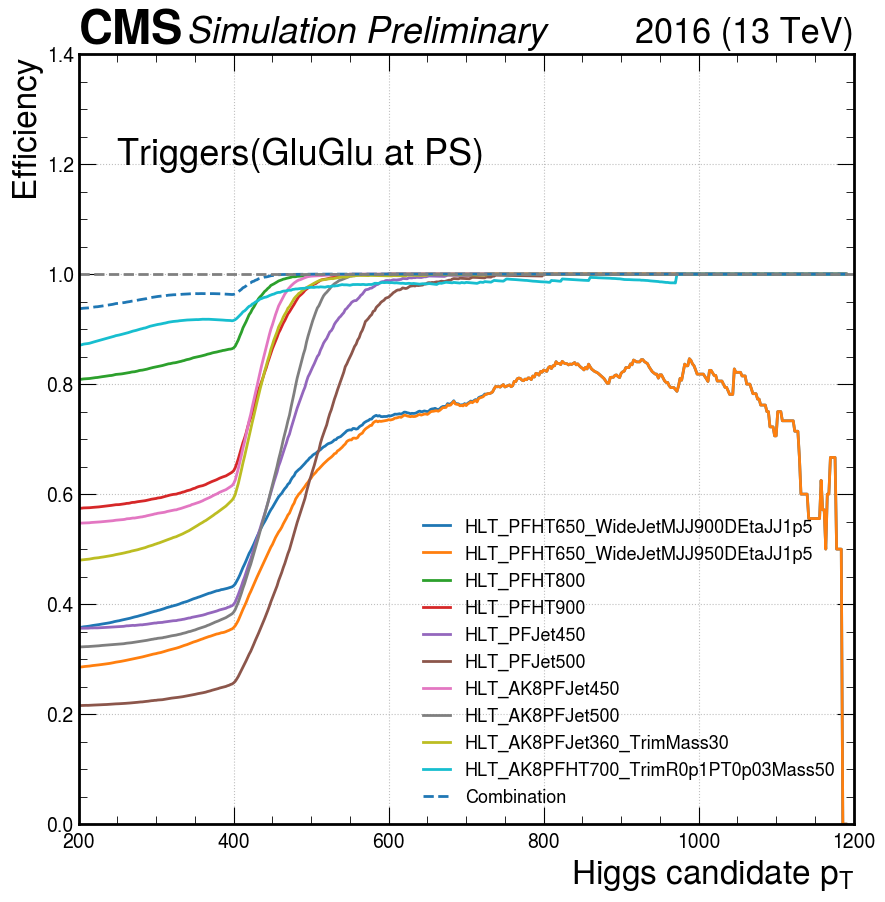

/home/pku/zhaoyz/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


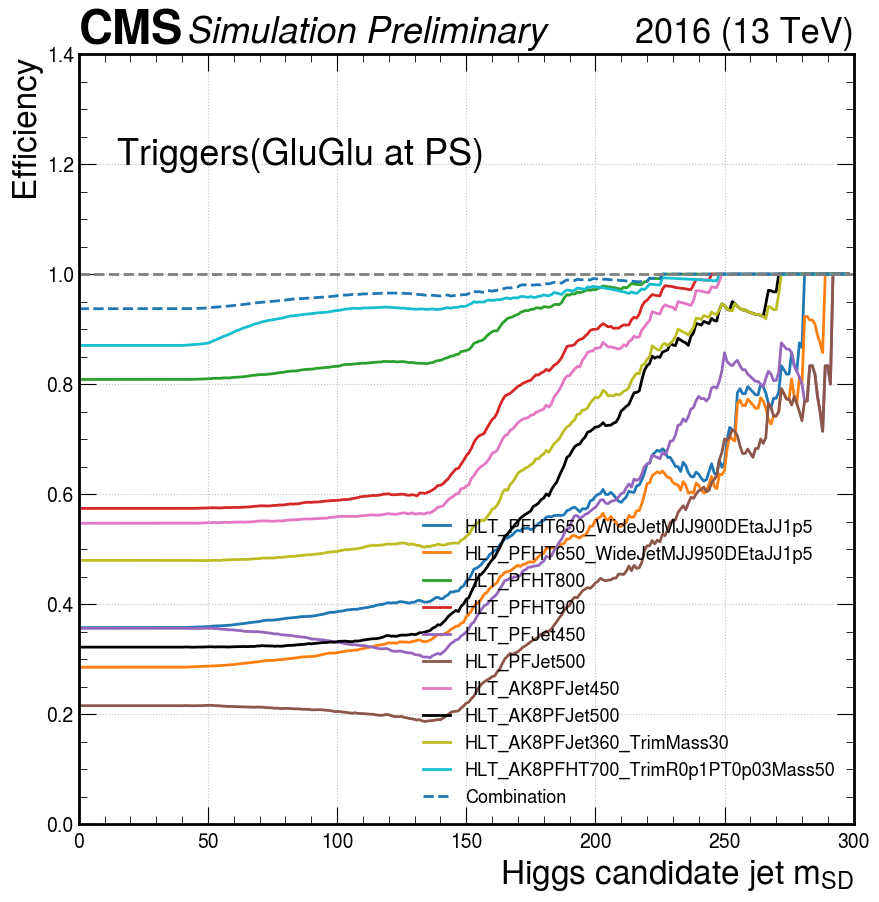

/home/pku/zhaoyz/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


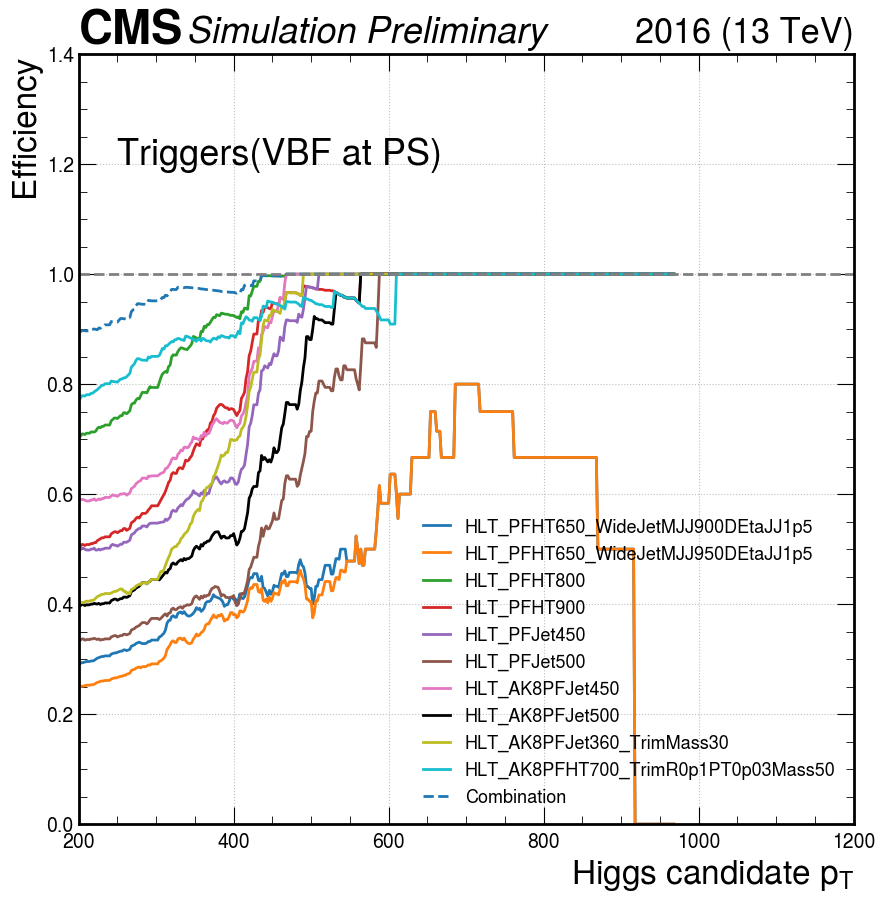

/home/pku/zhaoyz/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


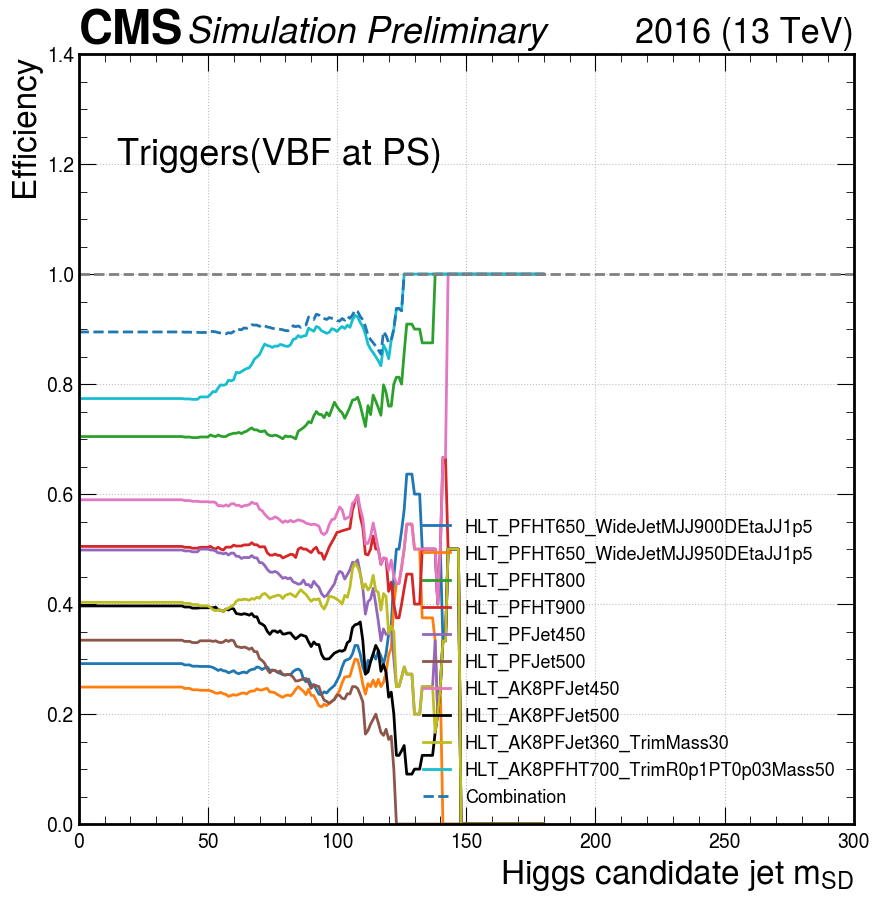

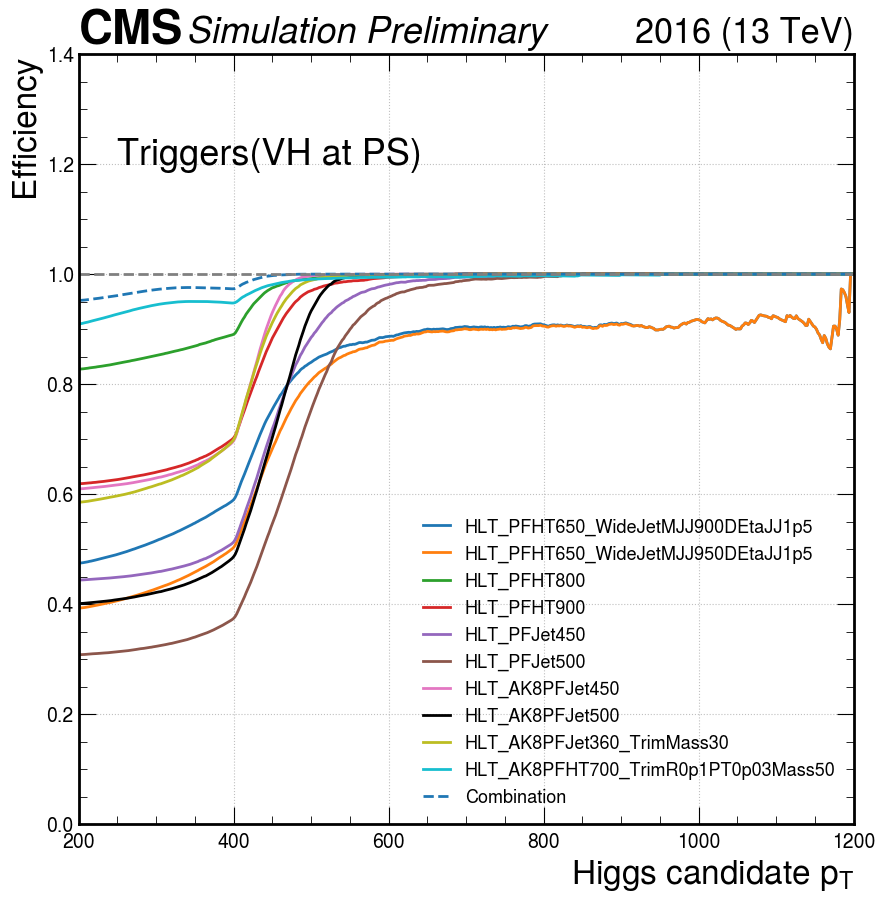

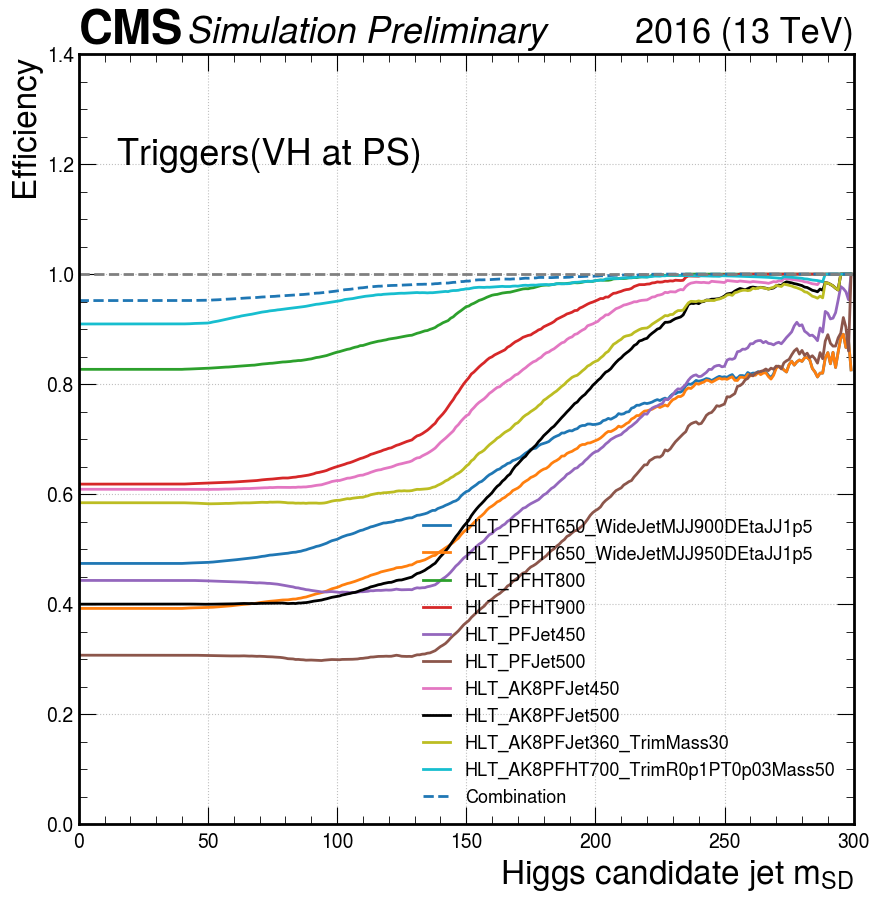

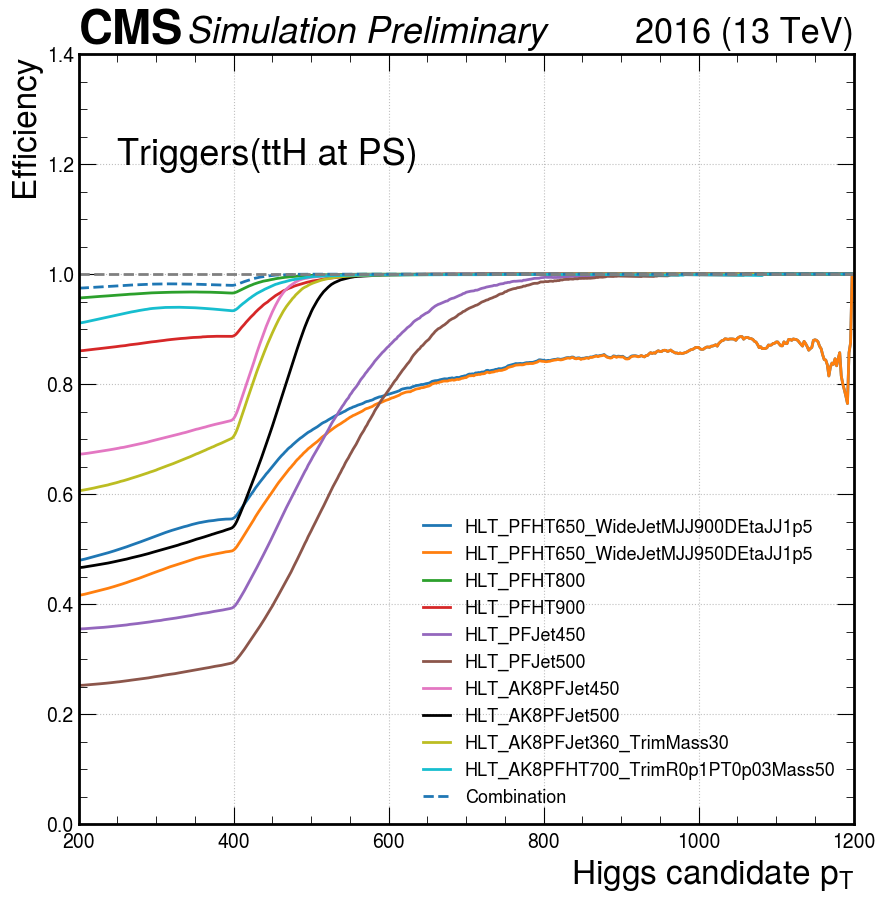

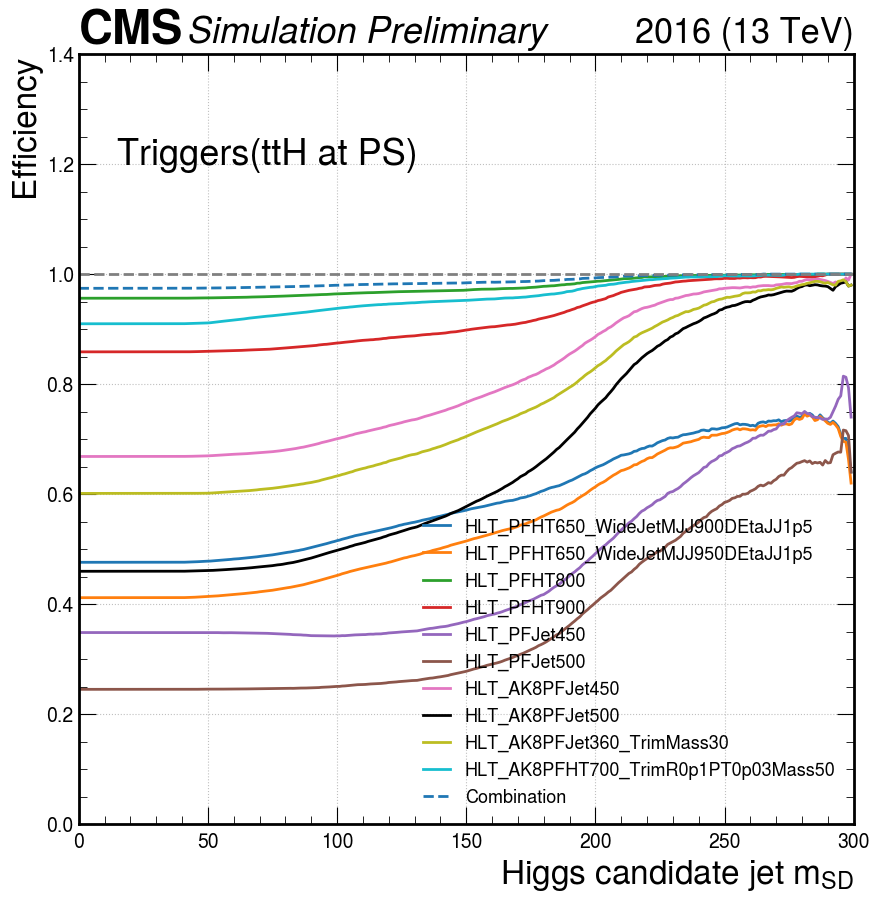

In [3]:
plot_effi(events=events["GluGlu"], x_label="PTj_V2_a", y_label = "GluGlu", xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["GluGlu"], x_label="Mj_V2_a",  y_label = "GluGlu", xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')

plot_effi(events=events["VBF"], x_label="PTj_V2_a", y_label = "VBF", xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["VBF"], x_label="Mj_V2_a",  y_label = "VBF", xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')

plot_effi(events=events["VH"], x_label="PTj_V2_a", y_label = "VH", xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["VH"], x_label="Mj_V2_a",  y_label = "VH", xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')

plot_effi(events=events["ttH"], x_label="PTj_V2_a", y_label = "ttH", xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["ttH"], x_label="Mj_V2_a",  y_label = "ttH", xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')



In [ ]:
plot_effi(events=events["Signal"], x_label="PTj_V2_a", y_label = "Signal", xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["Signal"], x_label="Mj_V2_a", y_label = "Signal", xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')
# plot_effi(events=events["Signal"], x_label="Mj_max", y_label = "Signal", xmin = 0, xmax = 300, bins = 300, legend_location='lower right')
# plot_effi(events=events["Signal"], x_label="Mj", y_label = "Signal", xmin = 0, xmax = 300, bins = 300, legend_location='lower right')
# plot_effi(events=events["Signal"], x_label="PTj", y_label = "Signal", xmin = 300.0, xmax = 800.0, bins = 500, legend_location='lower right')
# plot_effi(events=events["Signal"], x_label="PTj_max", y_label = "Signal", xmin = 300.0, xmax = 800.0, bins = 500, legend_location='lower right')
# plot_effi(events=events["Signal"], x_label="HT", y_label = "Signal", xmin = 300.0, xmax = 3000.0, bins = 500, legend_location='lower right')

In [ ]:
# plot_effi(events=events["QCD"], x_label="PTj_V2_a", y_label = "QCD",  xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')

In [ ]:
plot_effi(events=events["QCD"], x_label="PTj_V2_a", y_label = "QCD",  xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["QCD"], x_label="Mj_V2_a",  y_label = "QCD",  xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')
# plot_effi(events=events["QCD"], x_label="Mj_max",   y_label = "QCD",  xmin = 0, xmax = 300, bins = 300, legend_location='lower right')
# plot_effi(events=events["QCD"], x_label="Mj",       y_label = "QCD",  xmin = 0, xmax = 300, bins = 300, legend_location='lower right')
# plot_effi(events=events["QCD"], x_label="PTj",      y_label = "QCD",  xmin = 300.0, xmax = 800.0, bins = 500, legend_location='lower right')
# plot_effi(events=events["QCD"], x_label="PTj_max",  y_label = "QCD",  xmin = 300.0, xmax = 800.0, bins = 500, legend_location='lower right')
# plot_effi(events=events["QCD"], x_label="HT",       y_label = "QCD",  xmin = 300.0, xmax = 3000.0, bins = 500, legend_location='lower right')

In [ ]:
plot_effi(events=events["Data"], x_label="PTj_V2_a", y_label = "JetHT", isData = True,  xmin = 200.0, xmax = 1200.0, bins = 500, legend_location='lower right')
plot_effi(events=events["Data"], x_label="Mj_V2_a",  y_label = "JetHT", isData = True,  xmin = 0.0, xmax = 300.0, bins = 300, legend_location='lower right')
# plot_effi(events=events["Data"], x_label="Mj_max",   y_label = "JetHT", isData = True,  xmin = 0, xmax = 300, bins = 300, legend_location='lower right')
# plot_effi(events=events["Data"], x_label="Mj",       y_label = "JetHT", isData = True,  xmin = 0, xmax = 300, bins = 300, legend_location='lower right')
# plot_effi(events=events["Data"], x_label="PTj",      y_label = "JetHT", isData = True,  xmin = 300.0, xmax = 800.0, bins = 500, legend_location='lower right')
# plot_effi(events=events["Data"], x_label="PTj_max",  y_label = "JetHT", isData = True,  xmin = 300.0, xmax = 800.0, bins = 500, legend_location='lower right')
# plot_effi(events=events["Data"], x_label="HT",       y_label = "JetHT", isData = True,  xmin = 300.0, xmax = 3000.0, bins = 500, legend_location='lower right')